# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [9]:
import zipfile
import pandas as pd
import os

with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


In [16]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm

In [14]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)
print(X_test.shape)
print(X_train.shape)

(207, 9000)
(620, 9000)


In [39]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('feature_selection', RFECV(SVC(kernel='linear', gamma='scale'), step=100, cv=5)),
                 ('classifier', SVC(kernel='linear', gamma='scale'))
                    ])

parameters = {
    'C':            np.arange(1, 100).tolist(),
    'kernel':       ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':      ['scale', 'auto'], # only for rbf, poly and sigmoid kernels
    'degree':       [2, 3, 4, 5], # only for poly kernel
    'coef0':        np.linspace(0, 1, 10).tolist(), # only for poly and sigmoid kernels
    } 


model = RandomizedSearchCV(
    estimator=svm.SVC(),
    param_distributions=parameters,
    n_iter=50,
    n_jobs=5,
    cv=5,
    verbose=1,
    refit=True,
    scoring='roc_auc'  
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best Score:", model.best_score_)
print("best parameters:", model.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best estimator: SVC(C=36, coef0=0.8888888888888888, gamma='auto', kernel='linear')
Best Score: 0.777535656804646
best parameters: {'kernel': 'linear', 'gamma': 'auto', 'degree': 3, 'coef0': 0.8888888888888888, 'C': 36}


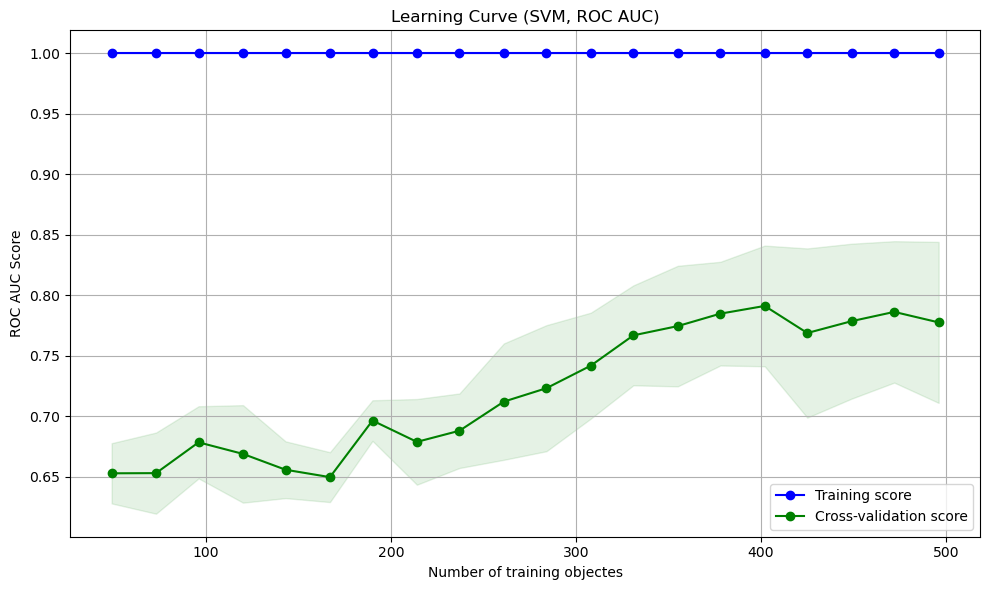

In [40]:
from sklearn.model_selection import learning_curve

#Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model.best_estimator_,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 20),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (SVM, ROC AUC)")
plt.xlabel("Number of training objectes")
plt.ylabel("ROC AUC Score")

plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")

plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.tight_layout()
plt.show()